# Initial Setup

In [1]:
%%time

# Load packages.
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib.pyplot import subplots
from statsmodels.graphics.tsaplots import plot_acf
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS, summarize, contrast

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

CPU times: user 2.72 s, sys: 1.9 s, total: 4.63 s
Wall time: 1.45 s


# Laboratory

## Explore Smarket Data Set

In [2]:
# Load data.
Smarket = load_data("Smarket")
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


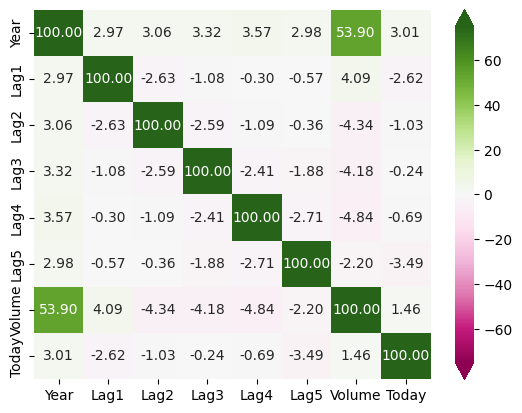

In [3]:
data = Smarket.drop(labels=["Direction"], axis=1).corr()
scale = 100
ax = sns.heatmap(
    data=scale * data,
    vmin=scale * -0.75,
    vmax=scale * 0.75,
    annot=True,
    fmt=".2f",
    cmap=plt.cm.PiYG,
    cbar_kws={"extend": "both"}
)

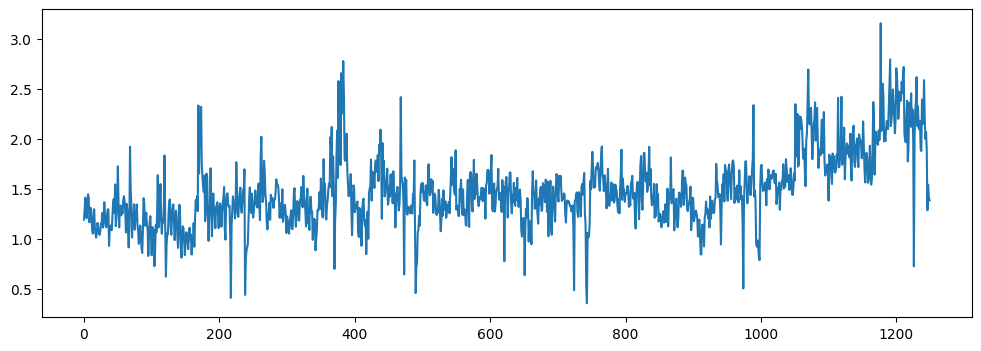

In [4]:
_ = Smarket.Volume.plot(figsize=(12, 4))

In [5]:
Smarket[Smarket.Direction == "Up"].shape

(648, 9)

In [6]:
Smarket[Smarket.Direction == "Down"].shape

(602, 9)

CPU times: user 3.02 s, sys: 2.09 s, total: 5.11 s
Wall time: 1.04 s


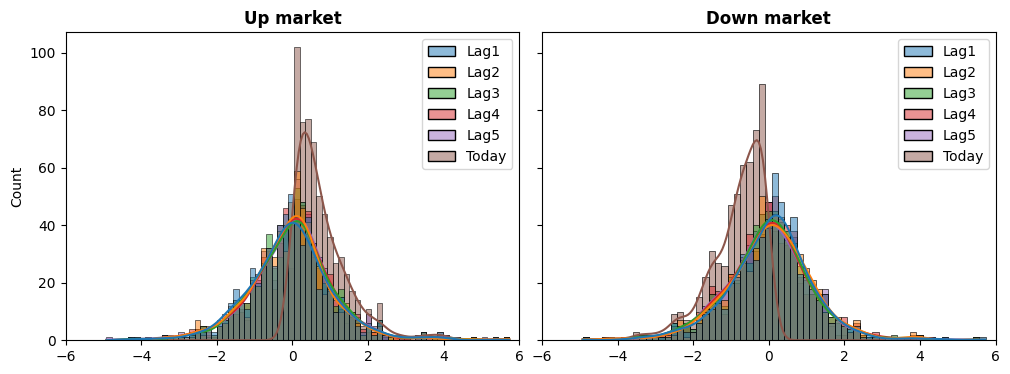

In [7]:
%%time

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.histplot(
    data=Smarket[Smarket.Direction == "Up"].drop(labels=["Year", "Volume"], axis=1),
    kde=True,
    ax=axs[0]
)
sns.histplot(
    data=Smarket[Smarket.Direction == "Down"].drop(labels=["Year", "Volume"], axis=1),
    kde=True,
    ax=axs[1]
)
axs[0].set_xlim((-6, 6))
axs[0].set_title("Up market", weight="bold")
_ = axs[1].set_title("Down market", weight="bold")
plt.subplots_adjust(wspace=0.05)

## Logistic regression

In [8]:
%%time 

predictors = Smarket.columns.drop (["Today", "Direction", "Year"])

design = MS(predictors)
Xp = design.fit_transform(Smarket)
y = (Smarket.Direction == "Up").astype(int)
glm = sm.GLM(
    endog=y,
    exog=Xp,
    family=sm.families.Binomial()
)
results = glm.fit()
summarize(results)

CPU times: user 89.5 ms, sys: 0 ns, total: 89.5 ms
Wall time: 89 ms


,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [9]:
cut_prob = 0.5
nobs = Smarket.shape[0]

probs = results.predict ()
labels = np.array(nobs * ["Down"])
labels[probs > cut_prob] = "Up"

confusion_table(labels , Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [10]:
(507 + 145) /1250 , np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [11]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [12]:
X_train , X_test = Xp.loc[train], Xp.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [13]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [14]:
labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [15]:
100 * np.mean(labels == L_test), 100 * np.mean(labels != L_test)

(48.01587301587302, 51.98412698412699)

In [16]:
model = MS(["Lag1", "Lag2"]).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array (252 * ["Down"])
labels[probs >0.5] = "Up"

confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [17]:
newdata = pd.DataFrame ({"Lag1": [1.2, 1.5], "Lag2": [1.1, -0.8]})
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

## Linear Discriminat Analysis

In [18]:
%%time

lda = LDA(store_covariance=True)

X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
lda.fit(X_train , L_train)

CPU times: user 6.83 ms, sys: 0 ns, total: 6.83 ms
Wall time: 6.45 ms


LinearDiscriminantAnalysis(store_covariance=True)

In [19]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [20]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [21]:
lda.priors_

array([0.49198397, 0.50801603])

In [22]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [23]:
lda_pred = lda.predict(X_test)
lda_prob = lda.predict_proba(X_test)
confusion_table(lda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [24]:
np.sum(lda_prob[:,0] > 0.9)

0

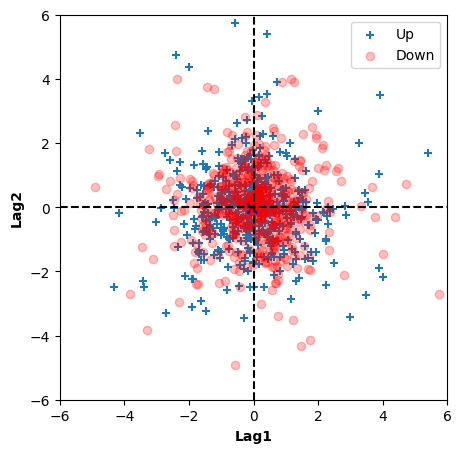

In [25]:
mask_up = y_train == 1
mask_down = y_train == 0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_train[mask_up].iloc[:, 0], X_train[mask_up].iloc[:, 1], alpha=1, marker="+", label="Up")
ax.scatter(X_train[mask_down].iloc[:, 0], X_train[mask_down].iloc[:, 1], color="red", alpha=0.25, label="Down")
ax.scatter(lda.means_[1, 0], lda.means_[1, 1], color="blue", marker="x", s=50)
ax.scatter(lda.means_[0, 0], lda.means_[0, 1], color="red", marker="x", s=50)
ax.set_xlabel(X_train.columns[0], weight="bold")
ax.set_ylabel(X_train.columns[1], weight="bold")
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))
ax.axvline(ls="--", color="black")
ax.axhline(ls="--", color="black")
_ = plt.legend()

## Quadratic Discriminant Analysis

In [26]:
qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [27]:
qda.means_ , qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [28]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [29]:
qda.covariance_[1]

array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])

In [30]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [31]:
100 * np.mean(qda_pred == L_test)

59.92063492063492

## Naive Bayes

In [32]:
NB = GaussianNB ()
NB.fit(X_train, L_train)

GaussianNB()

In [33]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [34]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [35]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [36]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [37]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels , L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


# Exercises

## Applied

### 13

**This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.**

In [38]:
df_weekly = load_data("Weekly")

# Show it.
df_weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


**(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?**

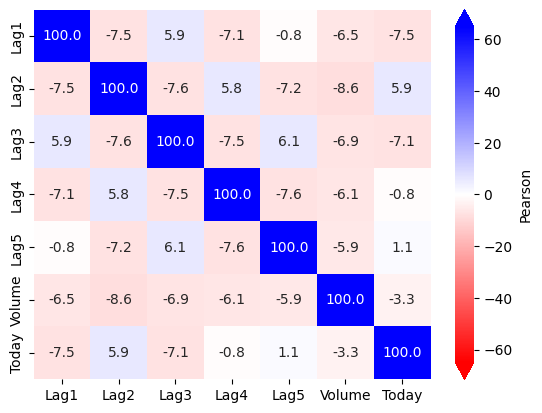

In [39]:
sns.heatmap(
    data=100 * df_weekly.drop(["Year", "Direction"], axis=1).corr(method="pearson"),
    vmin=100 * -0.65,
    vmax=100 * 0.65,
    cmap=plt.cm.bwr_r,
    annot=True,
    fmt=".1f",
    cbar_kws={"extend": "both", "label": "Pearson"}
);

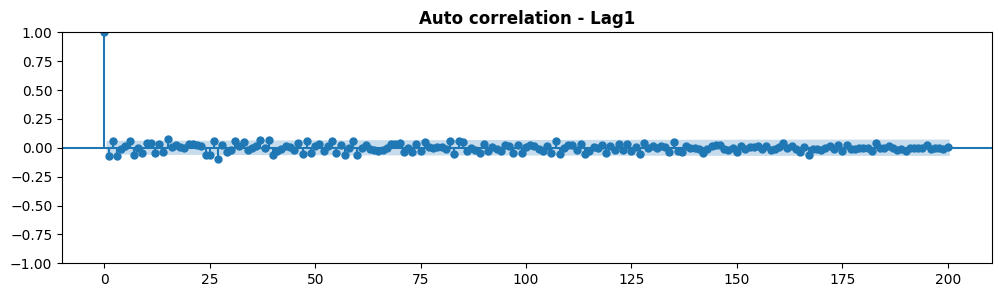

In [40]:
_, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_acf(x=df_weekly.Lag1, lags=200, ax=ax)
ax.set_title("Auto correlation - Lag1", weight="bold")
plt.show()

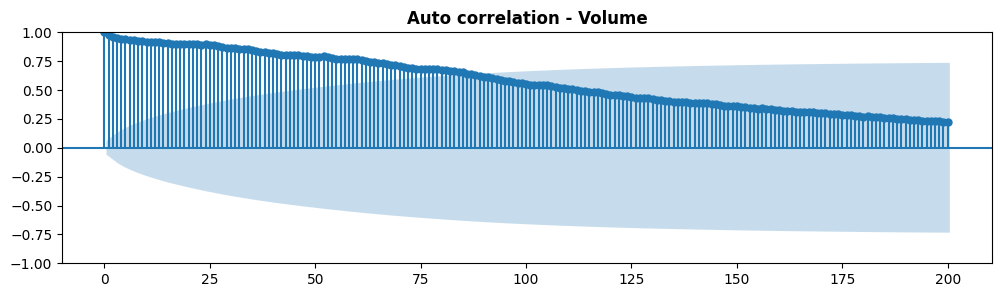

In [41]:
_, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_acf(x=df_weekly.Volume, lags=200, ax=ax)
ax.set_title("Auto correlation - Volume", weight="bold")
plt.show()

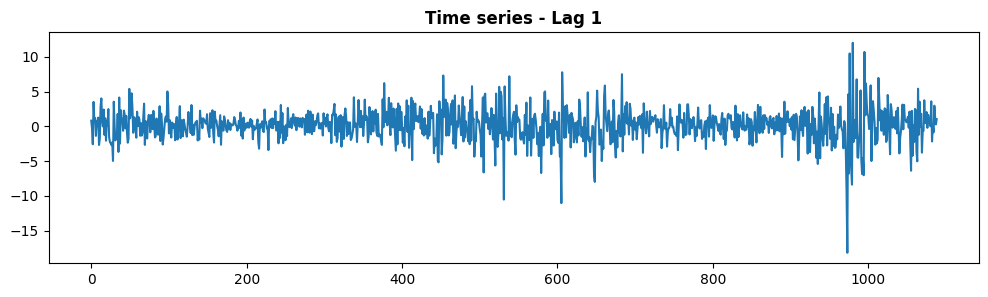

In [42]:
_, ax = plt.subplots(1, 1, figsize=(12, 3))
df_weekly.Lag1.plot(ax=ax)
ax.set_title("Time series - Lag 1", weight="bold")
plt.show()

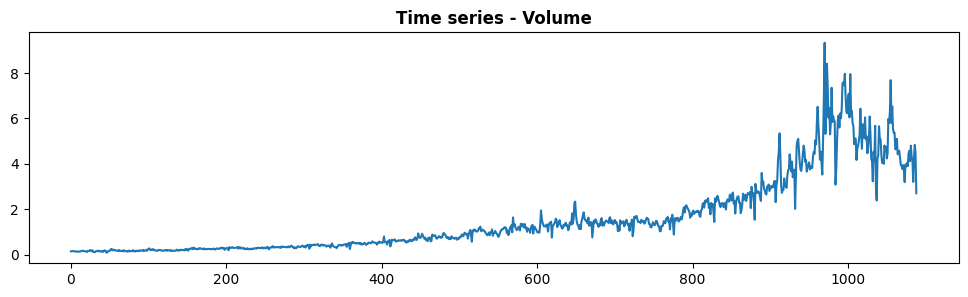

In [43]:
_, ax = plt.subplots(1, 1, figsize=(12, 3))
df_weekly.Volume.plot(ax=ax)
ax.set_title("Time series - Volume", weight="bold")
plt.show()

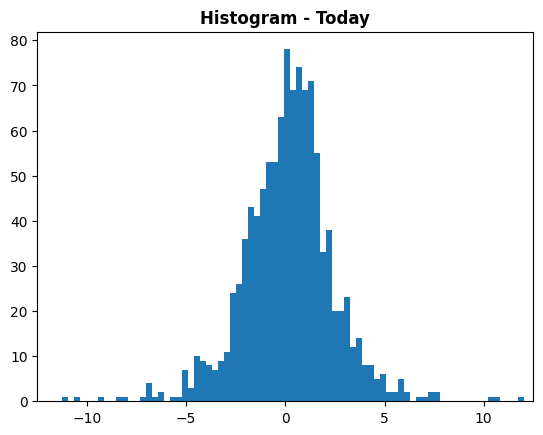

In [44]:
plt.hist(df_weekly.Today.values, bins=100)
plt.title("Histogram - Today", weight="bold")
plt.xlim((-12.5, 12.5));

**(b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?**

In [45]:
df_weekly["Direction_encoded"] = df_weekly["Direction"].map({"Down": 0, "Up": 1})

X = df_weekly.loc[:, ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]].copy(deep=True)
X = sm.add_constant(X)
y = df_weekly["Direction_encoded"].copy(deep=True)
results = sm.Logit(y, X).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      Direction_encoded   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                0.006580
Time:                        21:03:53   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

**(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.**

In [46]:
threshold = 0.5
y_pred = (results.predict(X) > threshold).astype(int).values

confusion_table(
    predicted_labels=pd.Series(y_pred).map({0: "Down", 1: "Up"}), 
    true_labels=y.map({0: "Down", 1: "Up"})
)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [47]:
cr = classification_report(
    y_pred=pd.Series(y_pred).map({0: "Down", 1: "Up"}),
    y_true=y.map({0: "Down", 1: "Up"})
)

print(cr)

              precision    recall  f1-score   support

        Down       0.53      0.11      0.18       484
          Up       0.56      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089



**(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).**

In [48]:
mask_train = df_weekly.Year <= 2008
mask_test = df_weekly.Year >= 2009

s_weekly_X_train = df_weekly[mask_train]["Lag2"].values.reshape((-1, 1))
s_weekly_y_train = df_weekly[mask_train]["Direction"].map({"Down": 0, "Up": 1}).values

s_weekly_X_test = df_weekly[mask_test]["Lag2"].values.reshape((-1, 1))
s_weekly_y_test = df_weekly[mask_test]["Direction"].map({"Down": 0, "Up": 1}).values

In [49]:
accuracies = {}

In [50]:
lr = LogisticRegression()
lr.fit(s_weekly_X_train, s_weekly_y_train)

y_weekly_test_pred = lr.predict(s_weekly_X_test)
y_weekly_test = s_weekly_y_test

cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test)

print(cr)

confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
print(f">>> Logistic Regression:")
print(f"    * Accurcy: {accuracy:.4f} %")

accuracies["Logistic Regression"] = accuracy

              precision    recall  f1-score   support

           0       0.64      0.21      0.32        43
           1       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104

>>> Logistic Regression:
    * Accurcy: 62.5000 %


**(e) Repeat (d) using LDA.**

In [51]:
lda = LDA()
lda.fit(s_weekly_X_train, s_weekly_y_train)

y_weekly_test_pred = lda.predict(s_weekly_X_test)
y_weekly_test = s_weekly_y_test

cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test)

print(cr)

ct = confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

print(ct); print("")

accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
print(f">>> Logistic Regression:")
print(f"    * Accurcy: {accuracy:.4f} %")

accuracies["LDA"] = accuracy

              precision    recall  f1-score   support

           0       0.64      0.21      0.32        43
           1       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104

Truth       0   1
Predicted        
0           9   5
1          34  56

>>> Logistic Regression:
    * Accurcy: 62.5000 %


**(f) Repeat (d) using QDA.**

In [52]:
qda = QDA()
qda.fit(s_weekly_X_train, s_weekly_y_train)

y_weekly_test_pred = qda.predict(s_weekly_X_test)
y_weekly_test = s_weekly_y_test

cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test, zero_division=0.0)

print(cr)

ct = confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

print(ct); print("")

accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
print(f">>> Logistic Regression:")
print(f"    * Accurcy: {accuracy:.4f} %")

accuracies["QDA"] = accuracy

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104

Truth       0   1
Predicted        
0           0   0
1          43  61

>>> Logistic Regression:
    * Accurcy: 58.6538 %


**(g) Repeat (d) using KNN with K = 1**

In [53]:
k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(s_weekly_X_train, s_weekly_y_train)

y_weekly_test_pred = knn.predict(s_weekly_X_test)
y_weekly_test = s_weekly_y_test

cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test)

print(cr)

ct = confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

print(ct); print("")

accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
print(f">>> KNN(k={k}):")
print(f"    * Accurcy: {accuracy:.4f} %")

accuracies[f"KNN(k={k})"] = accuracy

              precision    recall  f1-score   support

           0       0.41      0.51      0.45        43
           1       0.58      0.48      0.52        61

    accuracy                           0.49       104
   macro avg       0.49      0.49      0.49       104
weighted avg       0.51      0.49      0.49       104

Truth       0   1
Predicted        
0          22  32
1          21  29

>>> KNN(k=1):
    * Accurcy: 49.0385 %


**(h) Repeat (d) using naive Bayes**

In [54]:
nb = GaussianNB()
nb.fit(s_weekly_X_train, s_weekly_y_train)

y_weekly_test_pred = nb.predict(s_weekly_X_test)
y_weekly_test = s_weekly_y_test

cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test, zero_division=0.0)

print(cr)

ct = confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

print(ct); print("")

accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
print(f">>> Naive Bayes:")
print(f"    * Accurcy: {accuracy:.4f} %")

accuracies[f"Naive Bayes"] = accuracy

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104

Truth       0   1
Predicted        
0           0   0
1          43  61

>>> Naive Bayes:
    * Accurcy: 58.6538 %


**(i) Which of these methods appears to provide the best results on this data?**

In [55]:
# Show all results.
df_accuracies = pd.DataFrame.from_dict(
    data=accuracies, 
    orient="index", 
    columns=["percentual"]
).sort_values(by="percentual")

df_accuracies

,percentual
KNN(k=1),49.038462
QDA,58.653846
Naive Bayes,58.653846
LDA,62.500000
Logistic Regression,62.500000


**(j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.**

In [56]:
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 100]:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(s_weekly_X_train, s_weekly_y_train)

    y_weekly_test_pred = knn.predict(s_weekly_X_test)
    y_weekly_test = s_weekly_y_test

    cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test)

    print(cr)

    ct = confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

    print(ct); print("")

    accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
    print(f">>> KNN(k={k}):")
    print(f"    * Accurcy: {accuracy:.4f} %")

    accuracies[f"KNN(k={k})"] = accuracy

              precision    recall  f1-score   support

           0       0.41      0.72      0.53        43
           1       0.59      0.28      0.38        61

    accuracy                           0.46       104
   macro avg       0.50      0.50      0.45       104
weighted avg       0.51      0.46      0.44       104

Truth       0   1
Predicted        
0          31  44
1          12  17

>>> KNN(k=2):
    * Accurcy: 46.1538 %
              precision    recall  f1-score   support

           0       0.46      0.37      0.41        43
           1       0.61      0.69      0.65        61

    accuracy                           0.56       104
   macro avg       0.53      0.53      0.53       104
weighted avg       0.55      0.56      0.55       104

Truth       0   1
Predicted        
0          16  19
1          27  42

>>> KNN(k=3):
    * Accurcy: 55.7692 %
              precision    recall  f1-score   support

           0       0.49      0.60      0.54        43
           1 

In [57]:
s_weekly_X_train = df_weekly[mask_train][['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].values
s_weekly_y_train = df_weekly[mask_train]["Direction"].map({"Down": 0, "Up": 1}).values

s_weekly_X_test = df_weekly[mask_test][['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].values
s_weekly_y_test = df_weekly[mask_test]["Direction"].map({"Down": 0, "Up": 1}).values

lr = LogisticRegression()
lr.fit(s_weekly_X_train, s_weekly_y_train)

y_weekly_test_pred = lr.predict(s_weekly_X_test)
y_weekly_test = s_weekly_y_test

cr = classification_report(y_pred=y_weekly_test_pred, y_true=y_weekly_test)

print(cr)

ct = confusion_table(predicted_labels=y_weekly_test_pred, true_labels=y_weekly_test)

print(ct); print()

accuracy = 100 * np.mean(y_weekly_test == y_weekly_test_pred)
print(f">>> Logistic Regression (all lages and volume):")
print(f"    * Accurcy: {accuracy:.4f} %")

accuracies["Logistic Regression (all lags and volume)"] = accuracy

              precision    recall  f1-score   support

           0       0.41      0.72      0.53        43
           1       0.59      0.28      0.38        61

    accuracy                           0.46       104
   macro avg       0.50      0.50      0.45       104
weighted avg       0.51      0.46      0.44       104

Truth       0   1
Predicted        
0          31  44
1          12  17

>>> Logistic Regression (all lages and volume):
    * Accurcy: 46.1538 %


In [58]:
# Show all results.
df_accuracies = pd.DataFrame.from_dict(
    data=accuracies, 
    orient="index", 
    columns=["percentual"]
).sort_values(by="percentual", ascending=False)

df_accuracies

,percentual
Logistic Regression,62.500000
LDA,62.500000
QDA,58.653846
Naive Bayes,58.653846
KNN(k=4),57.692308
KNN(k=10),56.730769
KNN(k=100),56.730769
KNN(k=3),55.769231
KNN(k=9),55.769231
KNN(k=8),54.807692


### 14

In [59]:
df_auto = load_data("Auto")

df_auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


**(a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() method of the data frame. Note you may find it helpful to add a column mpg01 to the data frame by assignment. Assuming you have stored the data frame as Auto, this can be done as follows:**

In [60]:
median = df_auto["mpg"].median()
df_auto["mpg01"] = (df_auto["mpg"] > median).astype(int)
print(f">>> Median is {median}")
df_auto

>>> Median is 22.75


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,1
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,1
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,1
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,1


**(b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.**

In [61]:
df_auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,0.500000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,0.500639
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.500000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,1.000000


In [62]:
np.unique(df_auto["cylinders"].values, return_counts=True)

(array([3, 4, 5, 6, 8]), array([  4, 199,   3,  83, 103]))

In [63]:
df_auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
mpg01             int64
dtype: object

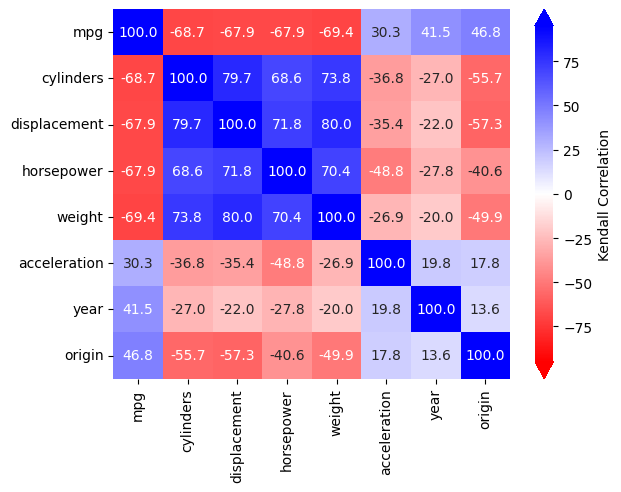

In [64]:
sns.heatmap(
    data=100 * df_auto.drop(["mpg01", "name"], axis=1).corr(method="kendall"),
    vmin=100 * -0.95,
    vmax=100 * 0.95,
    cmap=plt.cm.bwr_r,
    annot=True,
    fmt=".1f",
    cbar_kws={"extend": "both", "label": "Kendall Correlation"}
);

CPU times: user 4.92 s, sys: 434 ms, total: 5.36 s
Wall time: 4.6 s


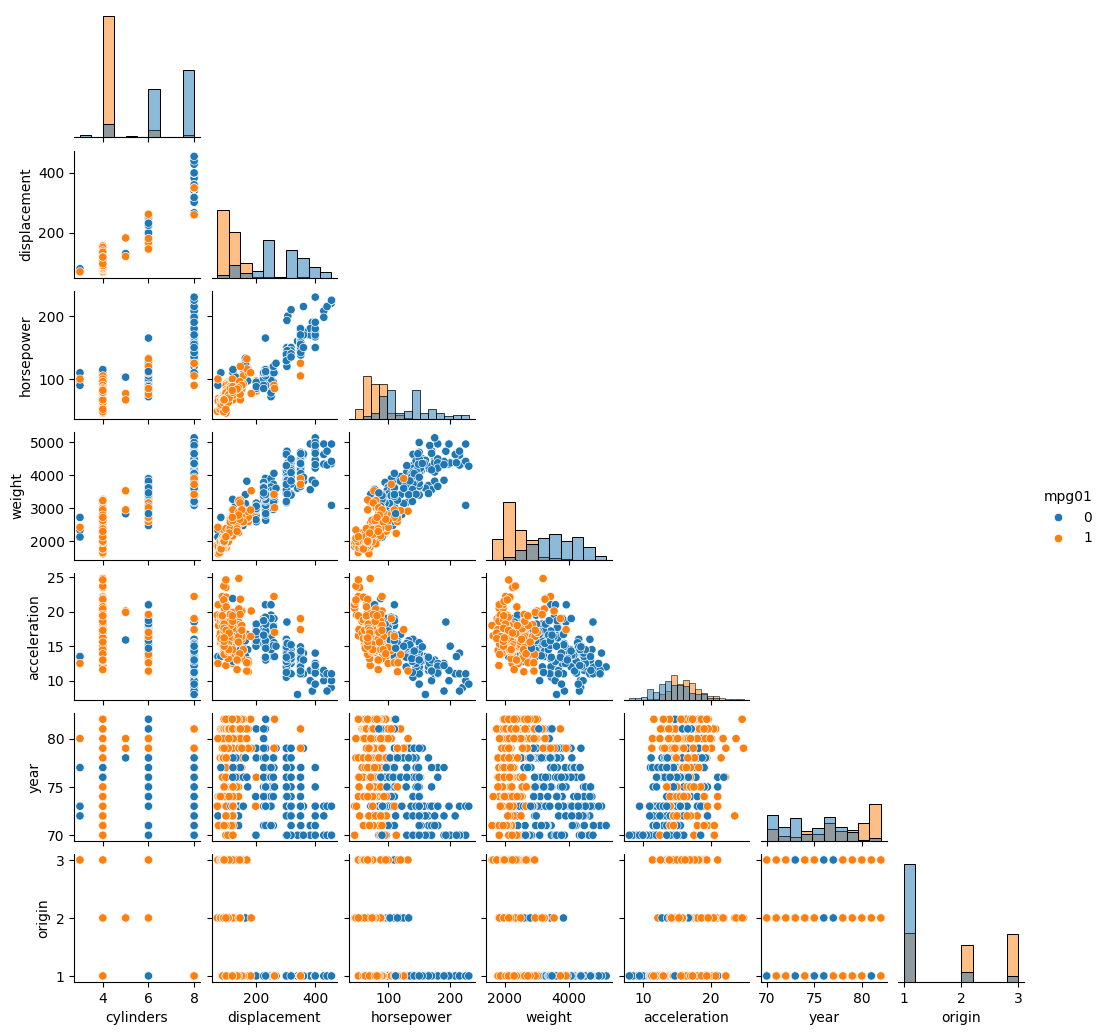

In [65]:
%%time

varss = ["mpg01", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]
sns.pairplot(
    data=df_auto[varss],
    hue="mpg01",
    height=1.50,
    diag_kind="hist",
    corner=True
)

Possibly helpful features:
- cylinders;
- displacement;
- horsepower;
- weight;

**(c) Split the data into a training set and a test set.**

In [66]:
dfX_auto = df_auto[["cylinders", "displacement", "horsepower", "weight"]]
dfy_auto = df_auto["mpg01"]
dfX_auto_train, dfX_auto_test, dfy_auto_train, dfy_auto_test = train_test_split(
    dfX_auto, dfy_auto,
    test_size=0.25,
    stratify=dfy_auto.values
)

In [67]:
counts = np.unique(dfy_auto.values, return_counts=True)[1]
print(counts / counts.sum())
counts = np.unique(dfy_auto_train.values, return_counts=True)[1]
print(counts / counts.sum())
counts = np.unique(dfy_auto_test.values, return_counts=True)[1]
print(counts / counts.sum())

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


**(d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**

In [68]:
lda = LDA(store_covariance=True)
lda.fit(dfX_auto_train, dfy_auto_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [69]:
dfy_auto_test_pred = lda.predict(dfX_auto_test)

errors = {}

accuracy = 100 * np.mean(dfy_auto_test_pred == dfy_auto_test)
error = 100 - accuracy
print(f">>> LDA:")
print(f"    * Accurcy: {accuracy:.4f} %")
print(f"    * Error: {error:.4f} %")

errors["LDA"] = error

>>> LDA:
    * Accurcy: 85.7143 %
    * Error: 14.2857 %


**(e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**

In [70]:
qda = QDA(store_covariance=True)
qda.fit(dfX_auto_train, dfy_auto_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [71]:
dfy_auto_test_pred = qda.predict(dfX_auto_test)

accuracy = 100 * np.mean(dfy_auto_test_pred == dfy_auto_test)
error = 100 - accuracy
print(f">>> QDA:")
print(f"    * Accurcy: {accuracy:.4f} %")
print(f"    * Error: {error:.4f} %")

errors["QDA"] = error

>>> QDA:
    * Accurcy: 85.7143 %
    * Error: 14.2857 %


**(f) Perform logistic regression on the training data in order to pre- dict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**

In [72]:
%%time 

X_auto_train = MS(dfX_auto_train).fit_transform(dfX_auto_train)
X_auto_test = MS(dfX_auto_test).fit_transform(dfX_auto_test)
y_auto_train = dfy_auto_train.values

glm = sm.GLM(
    endog=y_auto_train,
    exog=X_auto_train,
    family=sm.families.Binomial()
)
results = glm.fit()
summarize(results)

CPU times: user 20.9 ms, sys: 327 µs, total: 21.2 ms
Wall time: 20 ms


,coef,std err,z,P>|z|
intercept,12.1114,2.014,6.013,0.000
cylinders,0.0484,0.418,0.116,0.908
displacement,-0.0151,0.010,-1.468,0.142
horsepower,-0.0403,0.017,-2.345,0.019
weight,-0.0021,0.001,-2.297,0.022


In [73]:
cut = 0.5
y_auto_test_preds = (results.predict(X_auto_test) >= cut).astype(int)

accuracy = 100 * np.mean(y_auto_test_preds == dfy_auto_test.values)
error = 100 - accuracy
print(f">>> Logistic Regression:")
print(f"    * Accurcy: {accuracy:.4f} %")
print(f"    * Error: {error:.4f} %")

errors["Logistic Regression"] = error

>>> Logistic Regression:
    * Accurcy: 85.7143 %
    * Error: 14.2857 %


**(g) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**

In [74]:
NB = GaussianNB ()
NB.fit(dfX_auto_train, dfy_auto_train)

GaussianNB()

In [75]:
dfy_auto_test_pred = NB.predict(dfX_auto_test)

accuracy = 100 * np.mean(dfy_auto_test_pred == dfy_auto_test)
error = 100 - accuracy
print(f">>> Naive Bayes:")
print(f"    * Accurcy: {accuracy:.4f} %")
print(f"    * Error: {error:.4f} %")

errors["Naive Bayes"] = error

>>> Naive Bayes:
    * Accurcy: 85.7143 %
    * Error: 14.2857 %


**(h) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?**

In [76]:
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 30, 100]:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(dfX_auto_train, dfy_auto_train)
    
    dfy_auto_test_pred = knn.predict(dfX_auto_test)
    
    accuracy = 100 * np.mean(dfy_auto_test_pred == dfy_auto_test)
    error = 100 - accuracy
    print(f">>> KNN (k={k}):")
    print(f"    * Accurcy: {accuracy:.4f} %")
    print(f"    * Error: {error:.4f} %")
    
    errors[f"KNN (k={k})"] = error

>>> KNN (k=1):
    * Accurcy: 82.6531 %
    * Error: 17.3469 %
>>> KNN (k=2):
    * Accurcy: 81.6327 %
    * Error: 18.3673 %
>>> KNN (k=3):
    * Accurcy: 83.6735 %
    * Error: 16.3265 %
>>> KNN (k=4):
    * Accurcy: 84.6939 %
    * Error: 15.3061 %
>>> KNN (k=5):
    * Accurcy: 85.7143 %
    * Error: 14.2857 %
>>> KNN (k=6):
    * Accurcy: 86.7347 %
    * Error: 13.2653 %
>>> KNN (k=7):
    * Accurcy: 83.6735 %
    * Error: 16.3265 %
>>> KNN (k=8):
    * Accurcy: 84.6939 %
    * Error: 15.3061 %
>>> KNN (k=9):
    * Accurcy: 84.6939 %
    * Error: 15.3061 %
>>> KNN (k=10):
    * Accurcy: 83.6735 %
    * Error: 16.3265 %
>>> KNN (k=30):
    * Accurcy: 82.6531 %
    * Error: 17.3469 %
>>> KNN (k=100):
    * Accurcy: 82.6531 %
    * Error: 17.3469 %


In [77]:
# Show all results.
df_errors = pd.DataFrame.from_dict(
    data=errors, 
    orient="index", 
    columns=["percentual"]
).sort_values(by="percentual")

df_errors

,percentual
KNN (k=6),13.265306
LDA,14.285714
Logistic Regression,14.285714
QDA,14.285714
KNN (k=5),14.285714
Naive Bayes,14.285714
KNN (k=4),15.306122
KNN (k=8),15.306122
KNN (k=9),15.306122
KNN (k=7),16.326531
